In [1]:
!pip install faiss-cpu sentence-transformers transformers scikit-learn pandas numpy pillow


In [23]:
pip install sentence-transformers transformers pillow tqdm


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [35]:
pip install fastapi uvicorn python-multipart pillow sentence-transformers transformers scikit-learn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import faiss
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import hashlib


## Step 1: Load and Preprocess Dataset

In [4]:
import pandas as pd
import re

# Load CSVs
twitter_df = pd.read_csv("/Users/karthikviyyuri/Documents/finalmini/datasets/twitter and reddit/Twitter_Data.csv")
reddit_df = pd.read_csv("/Users/karthikviyyuri/Documents/finalmini/datasets/twitter and reddit/Reddit_Data.csv")

# Rename columns for uniformity
twitter_df = twitter_df.rename(columns={"clean_text": "text", "category": "label"})
reddit_df = reddit_df.rename(columns={"clean_comment": "text", "category": "label"})

# Clean text (for Reddit)
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)                  # remove URLs
    text = re.sub(r"[^a-zA-Z\s]", "", text)              # remove non-alphabet characters
    return text.lower().strip()

reddit_df['text'] = reddit_df['text'].apply(clean_text)

# Remove NaN or invalid labels
twitter_df = twitter_df.dropna(subset=["label"])
reddit_df = reddit_df.dropna(subset=["label"])

# Convert labels to int
twitter_df['label'] = twitter_df['label'].astype(int)
reddit_df['label'] = reddit_df['label'].astype(int)

# Combine both datasets
combined_df = pd.concat([twitter_df, reddit_df], ignore_index=True)

# Shuffle the data (optional)
combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Save or return
combined_df.to_csv("/Users/karthikviyyuri/Documents/finalmini/datasets/text_dataset.csv", index=False)

print("✅ Preprocessing complete. Saved as 'cleaned_combined_text_dataset.csv'")


✅ Preprocessing complete. Saved as 'cleaned_combined_text_dataset.csv'


In [5]:
# Re-run this block to define and process the MVSA dataframe again from the uploaded file

import pandas as pd
import re
import os

# Load MVSA labeled text
mvsa_text_df = pd.read_excel("/Users/karthikviyyuri/Documents/finalmini/datasets/MVSA/LabeledText.xlsx")

# Convert .txt filenames to .jpg
mvsa_text_df['image_file'] = mvsa_text_df['File Name'].apply(lambda x: x.replace('.txt', '.jpg'))

# Normalize label text
mvsa_text_df['label'] = mvsa_text_df['LABEL'].str.lower().map({
    'negative': -1,
    'neutral': 0,
    'positive': 1
})

# Reconstruct image path from label
def build_image_path(row):
    label_map = {-1: "negative", 0: "neutral", 1: "positive"}
    folder = label_map.get(row['label'])
    if folder:
        return os.path.join(folder, row['image_file'])
    return None

mvsa_text_df['image_path'] = mvsa_text_df.apply(build_image_path, axis=1)

# Clean the text
def clean_text(text):
    text = str(text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    return text.lower().strip()

mvsa_text_df['clean_text'] = mvsa_text_df['Caption'].apply(clean_text)

# Show final result
mvsa_text_df[['image_path', 'clean_text', 'label']].head()



,image_path,clean_text,label
0,negative/1.jpg,how i feel today legday jelly aching gym,-1
1,negative/10.jpg,arrivatw absolute disgrace two carriages from ...,-1
2,positive/100.jpg,this is my valentines from of my nephews i am...,1
3,neutral/1000.jpg,betterfeelingfilms rt via instagram first day ...,0
4,positive/1001.jpg,zoes first love rattled johnnyharper,1


In [6]:
# Define full base path for all categories
base_image_dir = "/Users/karthikviyyuri/Documents/finalmini/datasets/MVSA/Images"

# Replace relative image paths with full paths
def build_full_image_path(row):
    label_map = {-1: "Negative", 0: "Neutral", 1: "Positive"}  # use folder names as-is
    folder = label_map.get(row['label'])
    if folder:
        return os.path.join(base_image_dir, folder, row['image_file'])
    return None

mvsa_text_df['image_path'] = mvsa_text_df.apply(build_full_image_path, axis=1)
mvsa_text_df[['image_path', 'clean_text', 'label']].head()


,image_path,clean_text,label
0,/Users/karthikviyyuri/Documents/finalmini/data...,how i feel today legday jelly aching gym,-1
1,/Users/karthikviyyuri/Documents/finalmini/data...,arrivatw absolute disgrace two carriages from ...,-1
2,/Users/karthikviyyuri/Documents/finalmini/data...,this is my valentines from of my nephews i am...,1
3,/Users/karthikviyyuri/Documents/finalmini/data...,betterfeelingfilms rt via instagram first day ...,0
4,/Users/karthikviyyuri/Documents/finalmini/data...,zoes first love rattled johnnyharper,1


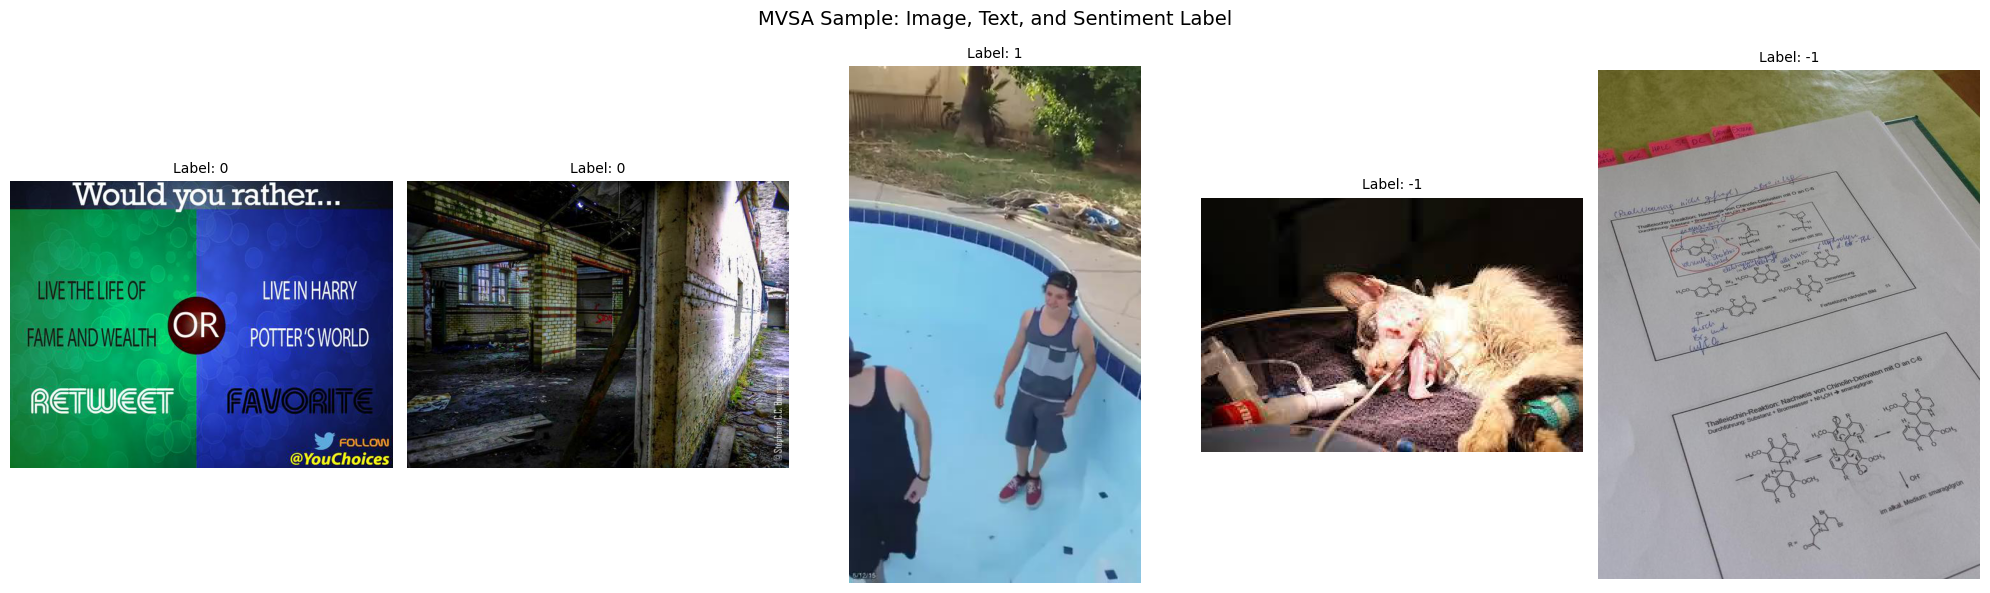

In [46]:
# Display image with corresponding text and label underneath as full output
sample = mvsa_text_df[['image_path', 'clean_text', 'label']].dropna().sample(5, random_state=247)

fig, axes = plt.subplots(1, 5, figsize=(20, 6))

for idx, (i, row) in enumerate(sample.iterrows()):
    try:
        img = Image.open(row['image_path']).convert("RGB")
        axes[idx].imshow(img)
        axes[idx].set_title(f"Label: {row['label']}", fontsize=10)
        axes[idx].set_xlabel(row['clean_text'][:40] + "..." if len(row['clean_text']) > 40 else row['clean_text'],
                             fontsize=8, wrap=True)
        axes[idx].axis("off")
    except Exception as e:
        axes[idx].text(0.5, 0.5, "Image Error", ha="center", va="center")
        axes[idx].axis("off")

plt.suptitle("MVSA Sample: Image, Text, and Sentiment Label", fontsize=14)
plt.tight_layout()
plt.show()


## Step 3: Generate Image Embeddings

In [8]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
import numpy as np
from tqdm import tqdm

# Load CLIP model
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device)

# Generate embeddings for all images
def get_image_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)
        return (image_features[0] / image_features[0].norm()).cpu().numpy()
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

# Apply to dataset
tqdm.pandas()
mvsa_text_df['image_embedding'] = mvsa_text_df['image_path'].progress_apply(get_image_embedding)

# Drop rows with failed image embeddings
mvsa_text_df = mvsa_text_df.dropna(subset=['image_embedding'])



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
100%|██████████| 4869/4869 [03:31<00:00, 23.06it/s]


## Step 4: Train Text and Image Sentiment Classifiers

In [10]:
# Recalculate the embeddings if not already present in the current session

from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch
from tqdm import tqdm

# Load models
text_model = SentenceTransformer("distilbert-base-nli-stsb-mean-tokens")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device)

# Text embeddings
tqdm.pandas()
mvsa_text_df['text_embedding'] = mvsa_text_df['clean_text'].progress_apply(lambda x: text_model.encode(x, normalize_embeddings=True))

# Image embeddings
def get_image_embedding(image_path):
    try:
        image = Image.open(image_path).convert("RGB")
        inputs = clip_processor(images=image, return_tensors="pt").to(device)
        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)
        return (image_features[0] / image_features[0].norm()).cpu().numpy()
    except Exception as e:
        return None

mvsa_text_df['image_embedding'] = mvsa_text_df['image_path'].progress_apply(get_image_embedding)

# Drop rows with missing embeddings
mvsa_text_df = mvsa_text_df.dropna(subset=['text_embedding', 'image_embedding'])



100%|██████████| 4869/4869 [04:22<00:00, 18.53it/s]


## Step 5: Create Cache and FAISS Index

In [11]:
import faiss
import numpy as np

# Stack embeddings
text_embeddings = np.stack(mvsa_text_df['text_embedding'].values)
image_embeddings = np.stack(mvsa_text_df['image_embedding'].values)

# Build indexes
text_faiss_index = faiss.IndexFlatIP(text_embeddings.shape[1])
image_faiss_index = faiss.IndexFlatIP(image_embeddings.shape[1])

text_faiss_index.add(text_embeddings)
image_faiss_index.add(image_embeddings)

# Check total vectors added
print(f"Text index size: {text_faiss_index.ntotal}")
print(f"Image index size: {image_faiss_index.ntotal}")



Text index size: 4869
Image index size: 4869


##FALL BACK CLASSIFIERS

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Train on BERT text embeddings
X_text = np.stack(mvsa_text_df['text_embedding'].values)
y = mvsa_text_df['label'].values
X_text_train, X_text_test, y_train, y_test = train_test_split(X_text, y, stratify=y, test_size=0.2)

text_clf = LogisticRegression(max_iter=1000).fit(X_text_train, y_train)

# Train on CLIP image embeddings
X_img = np.stack(mvsa_text_df['image_embedding'].values)
img_clf = LogisticRegression(max_iter=1000).fit(X_img, y)


## Step 6: Prediction with Cache Lookup

In [13]:
def predict_with_faiss(input_data, mode='text', threshold=0.90):
    if mode == 'text':
        emb = text_model.encode(input_data, normalize_embeddings=True)
        D, I = text_faiss_index.search(np.array([emb]), k=1)
        if D[0][0] > threshold:
            return {"sentiment": int(mvsa_text_df.iloc[I[0][0]]['label']), "source": "cache"}
        return {"sentiment": int(text_clf.predict([emb])[0]), "source": "classifier"}

    elif mode == 'image':
        emb = get_image_embedding(input_data)
        D, I = image_faiss_index.search(np.array([emb]), k=1)
        if D[0][0] > threshold:
            return {"sentiment": int(mvsa_text_df.iloc[I[0][0]]['label']), "source": "cache"}
        return {"sentiment": int(img_clf.predict([emb])[0]), "source": "classifier"}



In [14]:
# Now that embeddings are generated, let's proceed with training the MLP on fused features

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split

# Prepare data
text_embeddings = np.stack(mvsa_text_df['text_embedding'].values)
image_embeddings = np.stack(mvsa_text_df['image_embedding'].values)
labels = mvsa_text_df['label'].values

# Multimodal fusion
fused_embeddings = np.hstack((text_embeddings, image_embeddings))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(fused_embeddings, labels, test_size=0.2, stratify=labels, random_state=42)

# Train MLP classifier
mlp = MLPClassifier(hidden_layer_sizes=(256, 128), activation='relu', solver='adam', max_iter=300, random_state=42)
mlp.fit(X_train, y_train)

# Evaluate
y_pred = mlp.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=3)

accuracy, report


(0.6848049281314168,
 '              precision    recall  f1-score   support\n\n          -1      0.649     0.680     0.664       291\n           0      0.662     0.599     0.629       354\n           1      0.736     0.781     0.758       329\n\n    accuracy                          0.685       974\n   macro avg      0.683     0.687     0.684       974\nweighted avg      0.683     0.685     0.683       974\n')

## Step 7: EVALUATION 


In [15]:
from sklearn.model_selection import train_test_split

X_text = np.stack(mvsa_text_df['text_embedding'].values)
X_image = np.stack(mvsa_text_df['image_embedding'].values)
y = mvsa_text_df['label'].values

X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y, test_size=0.2, stratify=y)
X_image_train, X_image_test, y_image_train, y_image_test = train_test_split(X_image, y, test_size=0.2, stratify=y)


In [16]:
from sklearn.linear_model import LogisticRegression

text_clf = LogisticRegression(max_iter=1000).fit(X_text_train, y_text_train)
image_clf = LogisticRegression(max_iter=1000).fit(X_image_train, y_image_train)


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TEXT Classifier Evaluation
y_text_pred = text_clf.predict(X_text_test)
print("📘 Text Classifier Metrics (BERT):")
print(classification_report(y_text_test, y_text_pred, digits=3))
print("Confusion Matrix (Text):")
print(confusion_matrix(y_text_test, y_text_pred))

# IMAGE Classifier Evaluation
y_image_pred = image_clf.predict(X_image_test)
print("\n🖼️ Image Classifier Metrics (CLIP):")
print(classification_report(y_image_test, y_image_pred, digits=3))
print("Confusion Matrix (Image):")
print(confusion_matrix(y_image_test, y_image_pred))


📘 Text Classifier Metrics (BERT):
              precision    recall  f1-score   support

          -1      0.628     0.643     0.635       291
           0      0.629     0.613     0.621       354
           1      0.737     0.742     0.739       329

    accuracy                          0.665       974
   macro avg      0.665     0.666     0.665       974
weighted avg      0.665     0.665     0.665       974

Confusion Matrix (Text):
[[187  75  29]
 [ 79 217  58]
 [ 32  53 244]]

🖼️ Image Classifier Metrics (CLIP):
              precision    recall  f1-score   support

          -1      0.461     0.385     0.419       291
           0      0.436     0.449     0.442       354
           1      0.470     0.523     0.495       329

    accuracy                          0.455       974
   macro avg      0.455     0.452     0.452       974
weighted avg      0.455     0.455     0.453       974

Confusion Matrix (Image):
[[112 104  75]
 [ 76 159 119]
 [ 55 102 172]]


In [18]:
import os
import joblib
import pickle
import faiss
import numpy as np

# ✅ Set your target path
save_path = "/Users/karthikviyyuri/Documents/finalmini"

# 1. Save the trained MLP model
joblib.dump(mlp, os.path.join(save_path, "mlp_model.pkl"))
print("✅ Saved: mlp_model.pkl")

# 2. Save FAISS indexes
faiss.write_index(text_faiss_index, os.path.join(save_path, "text_faiss.index"))
faiss.write_index(image_faiss_index, os.path.join(save_path, "image_faiss.index"))
print("✅ Saved: text_faiss.index and image_faiss.index")

# 3. Build and save FAISS cache dictionaries
text_cache = {i: int(label) for i, label in enumerate(mvsa_text_df['label'].values)}
image_cache = {i: int(label) for i, label in enumerate(mvsa_text_df['label'].values)}

with open(os.path.join(save_path, "text_cache.pkl"), "wb") as f:
    pickle.dump(text_cache, f)

with open(os.path.join(save_path, "image_cache.pkl"), "wb") as f:
    pickle.dump(image_cache, f)

print("✅ Saved: text_cache.pkl and image_cache.pkl")
print("🎉 All files are saved in:", save_path)


✅ Saved: mlp_model.pkl
✅ Saved: text_faiss.index and image_faiss.index
✅ Saved: text_cache.pkl and image_cache.pkl
🎉 All files are saved in: /Users/karthikviyyuri/Documents/finalmini


In [ ]:
/Users/karthikviyyuri/Documents/finalmini/final_multimodal_sentiment_app/image_cache.pkl
/Users/karthikviyyuri/Documents/finalmini/final_multimodal_sentiment_app/image_faiss.index
/Users/karthikviyyuri/Documents/finalmini/final_multimodal_sentiment_app/mlp_model.pkl
/Users/karthikviyyuri/Documents/finalmini/final_multimodal_sentiment_app/texr_cache.pkl
/Users/karthikviyyuri/Documents/finalmini/final_multimodal_sentiment_app/text_faiss.index



NameError: name 'Users' is not defined